# Convolutional Neural Network for Classifying Casting Defects

This document describes the basic procedure for training and assessing a Convolutional Neural Network (CNN) using the `keras` Python library.

## Objective

The objective of this model is automate the classification of images of castings from a manufacturing process into one of two categories: 

* Defective
* OK

A data set consisting of images of castings labelled according to these categories are [provided on kaggle](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product).  In summary, the data provider aims to develop an automated QA inspection process using computer vision; the reader may refer to the link for further details.

## Setup

The following libraries are required for the analysis:

In [17]:
import pathlib

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

# Personal libraries.
from source.utils import utils
from source.plots import plots

The following parameters are used to configure the model.  

In [18]:
BATCH_SIZE = 128
NO_EPOCHS = 30 
TRAIN_PROP = 1

The configuration settings control the following:

* `BATCH_SIZE`: The NN below is trained using [mini-batch gradient decent](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size).   This parameter sets the size of the mini-batch.
* `NO_EPOCHS`: An *epoch* refers to the model status after one entire cycle of the dataset has been used to update the weights.  The `NO_EPOCHS` parameter sets the number of complete cycles through the entire data set that the NN will be exposed to.
* `TRAIN_PROP`: Sets the proportion of data in the training set that will be used.  It should usually be 1.  However, during model development, it can be useful to adjust it to a small fraction e.g. 0.05 to run a quick 'test' of the setup.

## Data

The input data consists of test/training data organised in directories for each category:

In [19]:
%%bash
tree ../input -dn

../input
└── casting_data
    ├── test
    │   ├── def_front
    │   └── ok_front
    └── train
        ├── def_front
        └── ok_front

7 directories


Each directory contains image files and the directory name is the categorisation label i.e. defective versus OK.  Conveniently, this directory arrangement is in a form that the `keras` API expects and the labels for each image will be deduced from the directory names.  The data is pulled from kaggle using the [kaggle API](https://github.com/Kaggle/kaggle-api):

```
kaggle datasets download --unzip \
    ravirajsinh45/real-life-industrial-dataset-of-casting-product
```

During development, various outputs are generated, for example:

* Training curves
* Trained weights
* Evaluation assessments

These are all stored since the NN typically take a considerable amount to time to train, especially on a CPU.  By storing the completed model data, it is possible to reload it for later use rather than retraining the NN.

The paths to the input/output data are setup as follows:

In [20]:
input_dir = pathlib.Path.cwd().parent  / 'input'
data_sets = ('train', 'test')
train_dir, test_dir = [next(input_dir.rglob(ds)) for ds in data_sets]

output_dir = pathlib.Path.cwd().parent  / 'output'

NB. The `rglob` method is used above since it can be reused on an arbitrary folder structure to recursively find the test/train folders.

## Data Generators

The `ImageDataGenrator` class from `keras` is used to pre-process raw image data.  A large number of operations are available for [image augmentation](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/).
In this present case, the only pre-processing that is performed is to normalise the images.  Additionally, a validation set is partitioned from the training data.

In [21]:
trainval_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255
)

Note that there are three data sets:

* **Training Set**. Used to compute the updates to the NN weights i.e. for training.
* **Validation Set**.  Held-out from the training process and used to compute an unbiased loss function score at the completion of each epoch.  This is used to keep track of how well training is progressing.
* **Test Set**.  Held-out from the training process all together.  The test set is used after all training has taken place to make an unbiased assessment of the final model.

Examples of training images are shown below and more detail about what constitutes a defect is available from [the data contributor](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product).

Found 3758 images belonging to 1 classes.
Found 2875 images belonging to 1 classes.


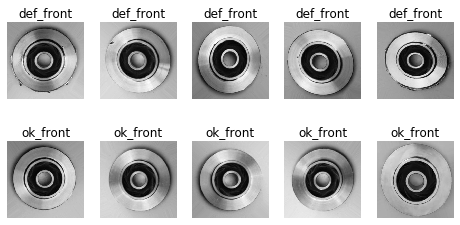

In [22]:
SEED_VALUE = 123456
example_images = utils.generate_examples(
    no_examples=5,
    idg=trainval_datagen,
    directory=train_dir,
    target_size=(300, 300),
    color_mode='grayscale',
    seed=SEED_VALUE
)
plots.plot_examples(example_images,
                    output_file=output_dir / 'example_images.png',
                    figsize=(8, 4))

The images are fed to the NN in *mini-batches* which are 'generated' via *generator* objects.  The use of generators and mini-batches has an advantage over loading all of the images at once in that only the data required for the current mini-batch is held in memory.  This enables very large sets of images to be fed to a NN without running into problems with memory allocation.

In [23]:
# Setup generators for train, validation and test data sets.
train_generator = trainval_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED_VALUE
)

validation_generator = trainval_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=SEED_VALUE
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(300, 300),
    color_mode='grayscale',
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


The generators above report the total number of images upon invocation.  Below, the total number of classes in the training set are summarised.

In [24]:
cnt = dict(utils.summarise_classes(train_generator))
cnt = {k : (v, 100 * v / sum(cnt.values())) for k, v in cnt.items()}
msg = "{:9s}: {} observations ({:4.1f}%)"
for cls, (count, prop) in cnt.items():
    print(msg.format(cls, count, prop))
    

def_front: 3007 observations (56.7%)
ok_front : 2300 observations (43.3%)


It is observed that the training example are fairly well balanced in terms of their class.

## Model Architecture

The model architecture is defined using the `Sequential` API in `keras`.  The architecture consists of 3 alternating `Conv2D` and `MaxPool2D` layers.  The convolutional layers respond to features in the images.  Examples of features may be may be horizontal lines, vertical lines, circles, etc.  In deep learning networks, the complexity of the features detected increases with the layer depth in the network.

The convolutional layers contain 32, 64 and 32 filters respectively.  During training, the weights will be updated such that each of the filters will respond to different features in the training set.  The training processes involves manipulating the NN weights such that the identified combination and layout of features (e.g. dark/light spots, jagged/smooth lines, variance/invariance) in a particular image will *activate* the most likely class to which the image belongs.

The pooling layers aggregate the outputs from the convolutions which has the advantage of a) reducing the number of weights required to train the network and b) combating over-fitting.

The final Flatten and Dense layers connect the output from the preceding layer to a single node.  This problem is one of *binary classification*.  The *sigmoid* activation function on the final node will vary between 0 and 1 and will model the probability of the image at the input to the NN corresponding to one class (1) or the other (0).

In [25]:
# Create neural network architecture.
model = Sequential([
    Conv2D(32, kernel_size=3, input_shape=(300, 300, 1), activation='relu'),
    MaxPool2D(4),
    Conv2D(64, kernel_size=3, input_shape=(300, 300, 1), activation='relu'),
    MaxPool2D(4),
    Conv2D(32, kernel_size=3, input_shape=(300, 300, 1), activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

The model summary shows the number of parameters (weights).  It is useful to consider this in the context of the size of the training set i.e. in general, the more parameters that there are, the more training data required.

## Model Compilation

Before the model can be trained, it must be *compiled*.  Firstly, an optimiser is specified.  In this case, the **adam** optimiser is chosen which, in summary, is [gradient decent](https://machinelearningmastery.com/gradient-descent-for-machine-learning/) featuring a learning rate that adjusts as training progresses. The name 'adam' is derived from 'Adaptive Moment Estimation' and it is often recommended as a robust optimisation algorithm.

The loss function is set to 'binary cross-entropy' which is appropriate for the current class of problem i.e. binary categorisation.  The binary cross-entropy quantifies how correct the model is.  Additionally, the metric, 'accuracy' is specified.  This is not used to assess the model but it is used in the output since it is easier to interpret than binary cross entropy.


In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

## Callbacks

Callbacks are functions that run at the end of each epoch.  A variety of useful callbacks are provided in `keras`.  In this case, the `ModelCheckpoint` callback is used which saves the weights in the model at the end of each epoch.  This is useful since model training takes a considerable amount to time of time and by using checkpoints, it is possible to reload trained, or partly trained, weights in a fresh session.

In [27]:
# Set up callbacks
checkpoint = ModelCheckpoint(
    str(output_dir / 'weights.hdf5'),
    monitor='val_loss'
)
callbacks_list = [checkpoint]

## Model Training 

The model is now ready to be trained.  The train steps per epoch are set such that most images in the training set will be used for training in each epoch and each image will only be used once in an epoch.  The aim is to expose to the NN to every image once in each epoch but since the number of training examples may not be exactly divisible by the `BATCH_SIZE`, some images may not be included in a given epoch.

After training the model, *learning curves* are plotted.  They show the history of the loss function computed for the training and validation data at the end of each epoch.  The learning curves are useful for assessing the quality of the model.   Also, they are a useful tool for diagnosing issues such as over-fitting or under-fitting, whether the model might benefit from running more epochs or whether it may benefit from more data.  A 'good' training curve would show both the training and validation error converging, in a stable fashion, to a small and similar loss function value.

Epoch 1/30
41/41 [==============================] - 62s 2s/step - loss: 0.6522 - accuracy: 0.6138 - val_loss: 0.5984 - val_accuracy: 0.7461

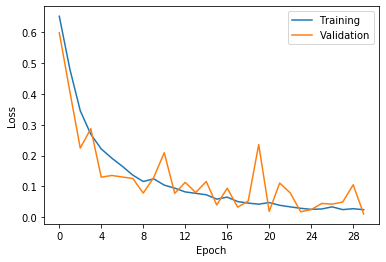

In [28]:
# Train model.
train_steps, val_steps = [TRAIN_PROP * (gen.samples // BATCH_SIZE)
                          for gen in (train_generator, validation_generator)]
training = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=NO_EPOCHS,
    callbacks=callbacks_list
)

plots.plot_learn(training, output_file=output_dir / 'training_curve.png')

## Evaluate model 

The final model is evaluated on the *test* set.  The accuracy is as follows:

In [29]:
test_loss, test_acc = model.evaluate_generator(test_generator)
print("Accuracy on test set: {:.3f}".format(test_acc))

Accuracy on test set: 0.983


Often, [confusion matrices](https://machinelearningmastery.com/confusion-matrix-machine-learning/) are a more appropriate method for assessing performance, especially for unbalanced classes.  The confusion matrix is as follows:

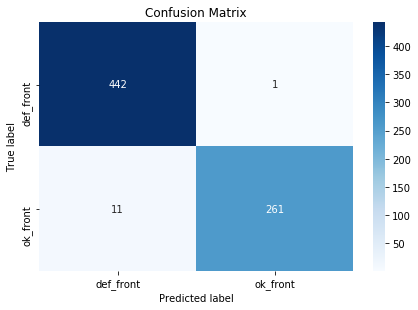

<Figure size 432x288 with 0 Axes>

In [30]:
# Calculate predicted probabilities, compute confusion matrix, plot.
pred_prob = model.predict_generator(test_generator)
pred_class = [1 if p > 0.5 else 0 for p in pred_prob]
true_class = test_generator.classes
labels = {v: k for k, v in test_generator.class_indices.items()}
labels = [labels[0], labels[1]]

cm = confusion_matrix(pred_class, true_class)

plots.plot_confusion_matrix(cm, labels=labels,
                            output_file=output_dir / 'confusion_matrix.png')